In [16]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import json
from datetime import datetime, timedelta

In [17]:
# 字符串转int数组，且处理空值
def parse_str_to_int(input_string):
    parts = input_string.split(',')
    int_list = [int(part) if part.strip() else 0 for part in parts]
    return int_list  

# 按照日期段，匹配数据和时间点
def group_data_df(input_string, start_date, end_date):
    data_points = parse_str_to_int(input_string)
    total_days = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days
    num_points = len(data_points) 
    interval = total_days / (num_points - 1)
    time_points = pd.date_range(start=start_date, periods=num_points, freq=f"{interval:.2f}D")

    df = pd.DataFrame({
        'Date': time_points,
        'Value': data_points
    })
    return df

# 按照年份聚合数据
def group_data_by_year(input_string, start_date, end_date):
    df = group_data_df(input_string, start_date, end_date)
    df['Year'] = df['Date'].dt.year
    yearly_data = df.groupby('Year')['Value'].sum().reset_index()
    return yearly_data

def show(filename):
    low_carbon = get_json(filename)
    data = group_data_by_year(low_carbon['PC+移动'], low_carbon['起始时间'], low_carbon['结束时间'])
    plt.figure(figsize=(10, 2))
    sns.lineplot(data=data, x='Year', y='Value',marker="o")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")

In [18]:
df = pd.read_csv('./data/search_index_all.csv')
cities = pd.read_csv('./data/study_cities.csv')['name'].tolist()

## 地级市

In [19]:
cities_en_name = pd.read_csv('./data/cities_en_name.csv')

In [20]:
def get_all_total_by_city():
    city_search_data_total = []
    for city in cities:
        T_all = 0
        rows = df[df.city==city]['total'].tolist()
        for r in rows:
            T_all += sum(parse_str_to_int(r))
        city_search_data_total.append([city, T_all])
    temp = pd.DataFrame(city_search_data_total, columns=['city', 'count'])
    temp = temp.sort_values(by='count', ascending=False)
    top10 = temp.head(10)
    top10 = pd.merge(top10, cities_en_name, left_on='city', right_on='name')
    del top10['name']
    # top10['en_name'] = (top10.index + 1).astype(str) + '# ' + top10['en_name']
    
    temp.to_csv('./QGIS/nationwide_total_count.csv', index=None)
    top10.to_csv('./QGIS/nationwide_total_count_top10.csv', index=None)
    return top10

get_all_total_by_city()

,city,count,longitude,latitude,en_name,pro_name,pro_en_name,pro_en_short
0,北京市,699761,116.407387,39.904179,Beijing,北京市,Beijing,BJ
1,上海市,564016,121.473667,31.230525,Shanghai,上海市,Shanghai,SH
2,广州市,401643,113.264499,23.130061,Guangzhou,广东省,Guangdong,GD
3,杭州市,396172,120.210792,30.246026,Hangzhou,浙江省,Zhejiang,ZJ
4,成都市,389436,104.066301,30.572961,Chengdu,四川省,Sichuan,SC
5,深圳市,386187,114.057939,22.543527,Shenzhen,广东省,Guangdong,GD
6,武汉市,332813,114.304569,30.593354,Wuhan,湖北省,Hubei,HB
7,南京市,331995,118.796624,32.059344,Nanjing,江苏省,Jiangsu,JS
8,重庆市,303083,106.550483,29.563707,Chongqing,重庆市,Chongqing,CQ
9,西安市,285840,108.939645,34.343207,Xi'an,陕西省,Shaanxi,SN


In [21]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

In [22]:
data = pd.read_csv('./QGIS/nationwide_total_count.csv')['count'].tolist()
ranks = np.arange(1, len(data) + 1) 
log_ranks = np.log(ranks)
log_frequencies = np.log(data)
slope, intercept, r_value, p_value, std_err = linregress(log_ranks, log_frequencies)
print(f"Slope (s): {-slope}")
print(f"R-squared: {r_value**2}")

Slope (s): 1.2028941099473813
R-squared: 0.7671200466601205


## 省份

In [23]:
def output_province():
    df_na = pd.read_csv('./QGIS/nationwide_total_count.csv')
    df_p = pd.merge(df_na, cities_en_name, left_on='city', right_on='name')
    provs = list(set(df_p['pro_name'].tolist()))

    rows = []
    for p in provs:
        target = df_p[df_p.pro_name==p]
        pro_sum = sum(target['count'].tolist())
        pro_en_name = target['pro_en_name'].values[0]
        pro_en_short = target['pro_en_short'].values[0]

        rows.append([p, pro_en_name, pro_en_short, pro_sum])
    temp = pd.DataFrame(rows, columns=['province', 'pro_en_name', 'pro_en_short', 'count'])
    temp = temp.sort_values(by='count', ascending=False)

    temp.to_csv('./QGIS/nationwide_province.csv', index=None)
    return temp

output_province()

,province,pro_en_name,pro_en_short,count
33,广东省,Guangdong,GD,1761340
18,江苏省,Jiangsu,JS,1549152
15,山东省,Shandong,SD,1385688
14,浙江省,Zhejiang,ZJ,1202686
7,河南省,Henan,HA,895236
20,河北省,Hebei,HE,835684
3,四川省,Sichuan,SC,829390
16,北京市,Beijing,BJ,699761
1,湖北省,Hubei,HB,689344
32,福建省,Fujian,FJ,656544


## 首位度

In [24]:
def output_first_city_within_province():
    df_na = pd.read_csv('./QGIS/nationwide_total_count.csv')
    df_p = pd.merge(df_na, cities_en_name, left_on='city', right_on='name')
    provs = list(set(df_p['pro_en_name'].tolist()))

    rows = []
    for p in provs:
        target = df_p[df_p.pro_en_name==p]
        top3 = target.sort_values(by='count', ascending=False).head(3)
        cou = top3['count'].tolist()
        t = top3['city'].tolist()
        t_en = top3['en_name'].tolist()
        if len(t) >= 2:
            rows.append([t_en[0], t_en[1].split(' ')[0], p, cou[0]/cou[1]])
    temp = pd.DataFrame(rows, columns=['city_1', 'city_2', 'province','primacy_ratio'])
    temp = temp.sort_values(by='primacy_ratio', ascending=False)

    temp.to_csv('./R/province_primacy.csv', index=None)
    return temp

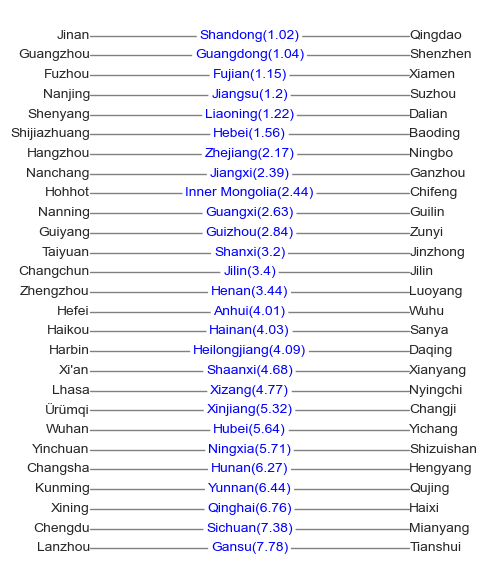

In [25]:
from matplotlib.patches import Rectangle

df = output_first_city_within_province()
df = df.reset_index(drop=True)
df['label'] = df['province'] + '(' + df['primacy_ratio'].round(2).astype(str) + ')'

fig, ax = plt.subplots(figsize=(5, 6))

for i, row in df.iterrows():
    ax.plot([1, 2, 3], [i, i, i], color='gray', linewidth=1)
    ax.text(1, i, row['city_1'], ha='right', va='center', fontsize=10)
    ax.text(3, i, row['city_2'], ha='left', va='center', fontsize=10)
    ax.text(
        2, i, row['label'],
        ha='center',
        va='center',
        color='blue',
        fontsize=10,
        bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2')  
    )

ax.set_xticks([])
ax.set_xticklabels([])
ax.get_yaxis().set_visible(False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.tight_layout()
plt.savefig('./R/province_primacy.pdf', format='pdf', bbox_inches='tight')
plt.show()

## 城市魅力指数 & 公众注意力

336


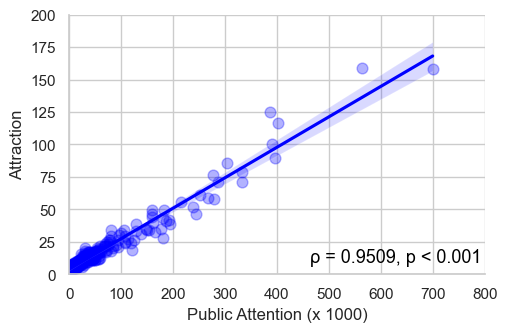

In [26]:
from scipy.stats import pearsonr, spearmanr
from matplotlib.ticker import FuncFormatter

att1 = pd.read_csv('./data/city_rank_2025.csv')[['城市', '新一线城市魅力指数']]
att1 = att1.rename(columns={'城市': 'city', '新一线城市魅力指数': 'Attraction_index'})
att1 = att1.dropna(subset=['Attraction_index'])

att_count = pd.read_csv('./QGIS/nationwide_total_count.csv')
att_count = att_count[att_count.city.isin(att1['city'])]
att2 = pd.merge(att_count, att1, on='city')
att2 = att2.rename(columns={'Attraction_index': 'Attraction', 'count': 'Attention'})
print(len(att2))

sns.set_theme(style="whitegrid")
g = sns.JointGrid(
    data=att2, 
    x="Attention", 
    y="Attraction", 
    xlim=(0, 800000), 
    ylim=(0, 200)
)

sns.regplot(
    data=att2, 
    x="Attention", 
    y="Attraction", 
    ax=g.ax_joint, 
    color="blue",
    scatter_kws={'alpha': 0.3, 's': 60} 
)

g.ax_marg_x.set_visible(False)
g.ax_marg_y.set_visible(False)

def scale_thousands(x, pos):
    return f'{int(x / 1000)}'

formatter = FuncFormatter(scale_thousands)
g.ax_joint.xaxis.set_major_formatter(formatter)
g.ax_joint.set_xlabel("Public Attention (x 1000)")

spearman_corr, spearman_p = spearmanr(att2["Attention"], att2["Attraction"])
spearman_text = (
    f"ρ = {spearman_corr:.4f}, "
    f"{'p < 0.001' if spearman_p < 0.001 else f'p = {spearman_p:.3f}'}"
)
g.ax_joint.text(
    0.58, 0.1,  
    spearman_text,
    transform=g.ax_joint.transAxes,  
    fontsize=13,
    color="black",
    ha="left",  
    va="top"    
)

plt.gcf().set_size_inches(6, 4)
plt.tight_layout()
plt.savefig('./R/attention_city_level.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [27]:
att2

,city,Attention,Attraction
0,北京市,699761,157.99
1,上海市,564016,158.62
2,广州市,401643,116.13
3,杭州市,396172,89.55
4,成都市,389436,100.00
...,...,...,...
331,黄南藏族自治州,1126,1.74
332,阿里地区,894,2.60
333,海北藏族自治州,893,1.43
334,玉树藏族自治州,678,1.50
